In [1]:
import matplotlib
preamble = r'''\usepackage{fontspec}
\setmainfont{Linux Libertine O}'''

fontsize = 17
ticklen = 5
params = {
    'font.size': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'text.usetex': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
    'xtick.major.size' : ticklen,
    'ytick.major.size' : ticklen,
    'xtick.minor.size' : ticklen/2,
    'ytick.minor.size' : ticklen/2
}
matplotlib.rcParams.update(params)

from mpl_toolkits.axes_grid1 import make_axes_locatable

import astropy.constants as const
from astropy.table import Table, Column
from astropy.io import fits
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")

import urllib.request

import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.colors

import pandas as pd

# from corner import corner
import corner

from tqdm import tqdm

from SPCA import Decorrelation_helper as dh

In [2]:
mainpath   = '/home/taylor/Documents/Research/spitzer/MEGA/'
rootpath = mainpath

planets = np.array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
                    'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
                    'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
                    'WASP-33b', 'KELT-9b'])
channels = ['ch2' for planet in planets]

In [3]:
def recompute_Tb(fp_MCMC, rp_MCMC, A_MCMC, planet, channel, rootpath):
    if channel=='ch1':
        wav=3.6e-6
    else:
        wav=4.5e-6
    
    nIters = 10000
    fp_MCMC = np.random.normal(fp_MCMC[0], np.mean(fp_MCMC[1:]), nIters)
    rp_MCMC = np.random.normal(rp_MCMC[0], np.mean(rp_MCMC[1:]), nIters)
    A_MCMC = np.random.normal(A_MCMC[0], np.mean(A_MCMC[1:]), nIters)
    
    tstar_b = compute_Tstarb(planet, channel, rootpath)
    tstar_b = np.random.normal(tstar_b[0], tstar_b[1], nIters)
    
    tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC/rp_MCMC**2)))**-1
    tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_b))-1)/(fp_MCMC*(1-2*A_MCMC)/rp_MCMC**2)))**-1
    
    return np.array([np.nanmedian(tday), np.nanpercentile(tday, 84)-np.nanmedian(tday), np.nanmedian(tday)-np.nanpercentile(tday, 16),
            np.nanmedian(tnight), np.nanpercentile(tnight, 84)-np.nanmedian(tnight), np.nanmedian(tnight)-np.nanpercentile(tnight, 16)])

def compute_Tstarb(planet, channel, rootpath):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.nanmean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.nanmean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.nanmean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    # Get the phoenix file ready to compute the stellar brightness temperature
    teffStr = Tstar
    if teffStr <= 7000:
        teffStr = teffStr - (teffStr%100) + np.rint((teffStr%100)/100)*100
    elif teffStr > 7000:
        teffStr = teffStr - (teffStr%200) + np.rint((teffStr%200)/200)*200
    elif teffStr > 12000:
        teffStr = 12000
    teffStr = str(int(teffStr)).zfill(5)
    
    logg = data['st_logg'][nameIndex]
    if np.isnan(logg):
        logg = 4.5
    logg = logg - (logg%0.5) + np.rint((logg%0.5)*2)/2.
    logg = -logg
    feh = data['st_metfe'][nameIndex]
    if np.isnan(feh):
        feh = 0.
    feh = (feh - (feh%0.5) + np.rint((feh%0.5)*2)/2.)
    if feh<-2.:
        feh = (feh - (feh%1) + np.rint((feh%1)))
    
    webfolder = 'ftp://phoenix.astro.physik.uni-goettingen.de/HiResFITS/'
    phoenixPath = rootpath+planet+'/phoenix/'
    phoenixWavFile = phoenixPath+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
    if not os.path.exists(phoenixPath):
        print('Downloading relevant PHOENIX wavelengths file...')
        os.mkdir(phoenixPath)
        try:
            _ = urllib.request.urlretrieve(webfolder+'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits', phoenixWavFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')

    webfolder += 'PHOENIX-ACES-AGSS-COND-2011/Z'+("{0:+.01f}".format(feh) if feh!=0 else '-0.0')+'/'

    webfile = ('lte'+teffStr
             +("{0:+.02f}".format(logg) if logg!=0 else '-0.00')
             +("{0:+.01f}".format(feh) if feh!=0 else '-0.0')
             +'.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

    phoenixSpectraFile = phoenixPath+webfile

    if not os.path.exists(phoenixSpectraFile):
        print('Downloading relevant PHOENIX spectra...')
        try:
            _ = urllib.request.urlretrieve(webfolder+webfile, phoenixSpectraFile)
        except:
            print('ERROR: No previously downloaded PHOENIX data - try again when you are connected to the internet.')
            exit()
        print('Done download.')
    
    f = fits.open(phoenixSpectraFile)
    fStar = f[0].data*1e-1 # 'erg/s/cm^2/cm' to kg/s^3
    f.close()
    f = fits.open(phoenixWavFile)
    wavStar = f[0].data*1e-4 # angstrom to micron
    f.close()

    def planck(wav, T):
        intensity = (2.0*const.h.value*const.c.value**2) / ((wav**5) * (np.exp(const.h.value*const.c.value/(wav*const.k_B.value*T)) - 1.0))
        return intensity
    def fluxDiff(temp, fStarSummed, wavs):
        #factor of pi likely needed to account for emitting area (pi*rstar^2 where rstar=1)
        return (np.sum(planck(wavs, temp)*np.pi)-fStarSummed)**2
    temps = np.linspace(3000, 11000, 801, endpoint=True)
    if channel == 'ch1':
        incides = np.where(np.logical_and(wavStar < 4., wavStar > 3.))[0]
    else:
        incides = np.where(np.logical_and(wavStar < 5., wavStar > 4.))[0]
    diffs = [fluxDiff(temp, np.sum(fStar[incides]), wavStar[incides]*1e-6) for temp in temps]
    tstar_b = temps[np.argmin(diffs)]
    
    return tstar_b, Tstar_err
    
def compute_T0(planet):
    if os.path.exists('../masterfile.ecsv'):
        data = Table.to_pandas(Table.read('../masterfile.ecsv'))
    else:
        print('ERROR: No previously downloaded Exoplanet Archive data - try again when you are connected to the internet.')
        print(FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), '../masterfile.ecsv'))
        exit()

    names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
    names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    
    if np.isfinite(data['pl_ratdor'][nameIndex]):
        a = data['pl_ratdor'][nameIndex]
        a_err = np.mean([data['pl_ratdorerr1'][nameIndex],
                                -data['pl_ratdorerr2'][nameIndex]])
    else:
        a = data['pl_orbsmax'][nameIndex]*const.au.value/data['st_rad'][nameIndex]/const.R_sun.value
        a_err = np.sqrt(
            (np.mean([data['pl_orbsmaxerr1'][nameIndex], -data['pl_orbsmaxerr2'][nameIndex]])*const.au.value
             /data['st_rad'][nameIndex]/const.R_sun.value)**2
            + (data['pl_orbsmax'][nameIndex]*const.au.value
               /data['st_rad'][nameIndex]**2/const.R_sun.value
               *np.mean([data['st_raderr1'][nameIndex], -data['st_raderr2'][nameIndex]]))**2
        )
    
    Tstar = data['st_teff'][nameIndex]
    Tstar_err = np.mean([data['st_tefferr1'][nameIndex],
                                -data['st_tefferr2'][nameIndex]])

    nIters = 10000
    Tstar = np.random.normal(Tstar, Tstar_err, nIters)
    a = np.random.normal(a, a_err, nIters)
    
    T0 = Tstar*np.sqrt(1/a)
    return np.array([np.median(T0), np.std(T0)])

In [4]:
import george
from george import kernels
from scipy.interpolate import interp1d
import scipy.constants as const2
import scipy.integrate as integral
c = const2.c
pi = const2.pi
h = const2.value('Planck constant')
k = const2.value('Boltzmann constant')
sig = const2.value('Stefan-Boltzmann constant')
const_1 = 2.0 * h * c ** 2
const_2 = h*c/k

# CONVERT BRIGHTNESS TEMPERATURE SPECTRUM TO EFFECTIVE TEMPERATURE
def Convert_to_T_eff(x, y):
    Temps = const_1 / (x ** 5 * (np.exp(const_2 / (x * y)) - 1))
    t_eff = abs(integral.trapz(Temps, x))
    t_eff = ((t_eff * pi) / sig) ** .25
    return t_eff


#  FIT BRIGHTNESS TEMPERATURE SPECTRUM WITH LINEAR INTERPOLATION METHOD
def linearInterpolation(domain, bds, y):
    LI = interp1d(bds, y)
    min_band = np.argmin(bds)
    max_band = np.argmax(bds)
    interp_y = [y[min_band] if wav < bds[min_band] else y[max_band] if wav > bds[max_band] else LI(wav) for wav in domain]
    return interp_y


#  ESTIMATE EFFECTIVE TEMPERATURE USING GP, LI, and EWM METHODS
def pass_uncerts(bds, y, yerr):
    domain = np.logspace(-7, -4, 100)
    divisor = 1e15
    
    domain_freq = np.array([c/lam/divisor for lam in domain])  # convert domain to frequency in petahertz
    new_bds = np.array([c / bd / divisor for bd in bds])  # convert bands to frequency in petahertz

    kernal_value = 0.1
    kern = kernels.ExpSquaredKernel(kernal_value)  # initialize covariance kernel

    functions_GP = []
    functions_LI = []

    randomized = np.array(list(map(np.random.normal, y, yerr, [100] * len(yerr)))).T
    ewms = []

    for y_rand in randomized:   # Monte Carlo

        # Error-weighted mean method
        av = np.average(y_rand, weights=1./yerr)
        ewms.append(av)

        # Setting up the GP
        y_rand /= av  # normalize the data
        model = george.GP(np.var(y_rand) * kern, mean=1.)
        model.compute(new_bds, yerr=yerr/av)

        # Setting the hyperparameters
        model["kernel:k1:log_constant"] = -4  # signal variance trained on exoplanets.org secondary eclipse sample
        model['kernel:k2:metric:log_M_0_0'] = -8.55  # length scale trained on HITEMP spectrum of water

        functions_GP.extend(model.sample_conditional(y_rand, domain_freq, 100) * av)  # 100 samples from posterior

    # calculate uncertainty & z-score for EMW method
    mean_mean = np.mean(ewms)
    std_mean = np.std(ewms)

    # convert brightness temperature functions to effective temperatures
    temps_GP = [Convert_to_T_eff(domain, pred) for pred in functions_GP]

    # calculate uncertainty & z-score for GP-fixed method
    mean_gp = np.mean(temps_GP)
    std_gp = np.std(temps_GP)

    return [mean_gp, std_gp]

In [5]:
def make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True, passUncert=True):
    lit = pd.read_csv('Literature_Values - Bell2020.tsv', delimiter='\t')
    lit = lit.iloc[np.where(lit['Planet']!='HD149026b')[0]]
    names_lit = np.array(lit['Planet'])
    
    rp_lit = np.array([lit['Rp'][i].split('+') for i in lit.index])
    rp_lit = np.array([['nan','nan'] if np.all(rp_lit[i]==['Unpublished']) else rp_lit[i] for i in range(len(rp_lit))]).astype(float)
    
    fp_lit = np.array([lit['Fp'][i].split('+') for i in lit.index])
    fp_lit = np.array([['nan','nan'] if np.all(fp_lit[i]==['Unpublished']) else fp_lit[i] for i in range(len(fp_lit))]).astype(float)
    
    amp_lit = np.array([lit['Semi-Amplitude'][i].split('+') for i in lit.index])
    amp_lit = np.array([['nan','nan'] if np.all(amp_lit[i]==['Unpublished']) else amp_lit[i] for i in range(len(amp_lit))]).astype(float)

    offset_lit = np.array([lit['Offset (E)'][i].split('+') for i in lit.index])
    offset_lit = np.array([['nan','nan'] if np.all(offset_lit[i]==['Unpublished']) else offset_lit[i] for i in range(len(offset_lit))]).astype(float)
    
    tday_temp = np.array([lit['Tday'][i].split('+') for i in lit.index])
    tday_lit = np.array([['nan','nan'] if np.all(tday_temp[i]==['Unpublished']) else tday_temp[i] for i in range(len(tday_temp))]).astype(float)

    tnight_temp = np.array([lit['Tnight'][i].split('+') for i in lit.index])
    tnight_lit = np.array([['nan','nan'] if (np.all(tnight_temp[i]==['Unpublished']) or np.all(tnight_temp[i]==['Upper limit'])) else tnight_temp[i] for i in range(len(tnight_temp))]).astype(float)
    
    if twoD:
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()
        cmap = matplotlib.cm.get_cmap('rainbow')
        cmap.set_over('black')
        norm = matplotlib.colors.Normalize(vmin=1670, vmax=3900)
    else:
        fig = plt.figure(figsize=(8,8))
        gs = fig.add_gridspec(2, 1, hspace=0.03)
        (ax1, ax2) = gs.subplots(sharex=True)
        
    
    for iterNum in range(len(planets)):
        channel = channels[iterNum]
        planet = planets[iterNum]

        print(planet)
        
        # Figure out where files are saved
        phoption = ''
        foldername = ''
        rms = None
        with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
            lines = f.readlines()
        for i in range(len(lines)):
            if phoption=='' and lines[i][0]=='/':
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            elif phoption!='' and lines[i][0]=='/':
                if float(lines[i+2]) < rms:
                    foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                    phoption = lines[i].split('/')[-1].strip()
                    i += 1
                    ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                    if np.all(ignoreFrames==['']):
                        ignoreFrames = np.array([]).astype(int)
                    else:
                        ignoreFrames = ignoreFrames.astype(int)
                    i += 1
                    rms = float(lines[i])
                else:
                    i += 3
        pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

        # Figure out what modes were run
        modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
        for i in range(len(pldFoldernames)):
            modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))
        
        #find the best modes
        BICs = []
        nDatas = []
        for mode in modes:
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            
            if not os.path.exists(savepath):
                BICs.append(np.inf)
                nDatas.append(1)
            else:
                ResultMCMC = np.load(savepath)
                BICs.append(-2*ResultMCMC['evidenceB'][0])
                nDatas.append(ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0])
        BICs = np.array(BICs)
        nDatas = np.array(nDatas)

        try:
            bestBIC = BICs[np.argmin(BICs/nDatas)]
        except:
            # There are no analyses for this planet
            continue


        for i in range(len(modes)):

            ######################## MAKE BESTFIT TABLE ########################

            if BICs[i] != bestBIC:
                continue

            mode = modes[i]
            if 'PLD' in mode:
                if channel=='ch2':
                    folder='4um'
                else:
                    folder='3um'
                if '3x3' in mode:
                    folder += 'PLD_3x3/'
                else:
                    folder += 'PLD_5x5/'
                savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            else:
                savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
            ResultMCMC = np.load(savepath)

            planetName = planet.split('_repeat')
            if len(planetName)>1:
                planetName = planetName[0]+' Repeat'+planetName[1][:-3]
            else:
                planetName = planetName[0]
            planetName = planet.split('_old')
            if len(planetName)>1:
                planetName = planetName[0]+' (2010)'+planetName[1][:-3]
            elif planetName[0]=='WASP-12b':
                planetName = 'WASP-12b (2013)'
            else:
                planetName = planetName[0]
            
            if literature and planet not in names_lit and planet not in ['MASCARA-1b', 'KELT-16b']:
                continue
            elif literature and planet not in ['MASCARA-1b', 'KELT-16b']:
                planetIndex = np.where(names_lit==planet)[0][0]
                
                n = int(1e4)
                fps = np.random.normal(fp_lit[planetIndex][0], fp_lit[planetIndex][1], n)
                amps = np.random.normal(amp_lit[planetIndex][0], amp_lit[planetIndex][1], n)
                offsets = np.random.normal(offset_lit[planetIndex][0], offset_lit[planetIndex][1], n)
                A = (amps*np.cos(np.pi-offsets*np.pi/180))/fps
                A = np.abs(np.append(np.median(A), np.percentile(A, [16, 84])-np.median(A)))

                if np.isnan(rp_lit[planetIndex][0]):
                    rp = ResultMCMC['rp']
                else:
                    rp = rp_lit[planetIndex]

                newTb = recompute_Tb(fp_lit[planetIndex]/1e6, rp, A,
                                     planet, channel, mainpath)

                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]

                print(lit['Reference'][planetIndex])
            else:
                newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                                     planet, channel, mainpath)
                Tday = newTb[[0,1,2]]
                Tnight = newTb[[3,4,5]]
            
            data = Table.to_pandas(Table.read('../masterfile.ecsv'))
            names = np.array(data['pl_hostname'])+np.array(data['pl_letter'])
            names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])
            nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
            Tstar = data['st_teff'][nameIndex]
            Tstar_err = np.nanmean([data['st_tefferr1'][nameIndex],
                                 -data['st_tefferr2'][nameIndex]])
            
            n = int(1.5e5)
            Tstar = np.random.normal(Tstar,  Tstar_err, n)
            a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
            a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
            a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
            
            if passUncert:
                # Update day and nightside uncertainties using Pass+2019
                bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
                td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
                td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
                tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
                tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)
                
                Tday = pass_uncerts(bands, td_brights, td_uncs)
                Tnight = pass_uncerts(bands, tn_brights, tn_uncs)
                
                Td = np.random.normal(Tday[0], Tday[1], n)
                Tn = np.random.normal(Tnight[0], Tday[1], n)
            else:
                Td_down = np.random.normal(Tday[0], Tday[2], n)
                Td_up = np.random.normal(Tday[0], Tday[1], n)
                Td = np.append(Td_down[Td_down<Tday[0]], Td_up[Td_up>=Tday[0]])
                
                Tn_down = np.random.normal(Tnight[0], Tnight[1], n)
                Tn_up = np.random.normal(Tnight[0], Tnight[2], n)
                Tn = np.append(Tn_down[Tn_down<Tnight[0]], Tn_up[Tn_up>=Tnight[0]])
            
            
            
            # print(Tstar, Tday[0], Tnight[0], ResultMCMC['a'][0])
            
            n = np.min([Td.size, Tn.size, Tstar.size, a.size])
            Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
            Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
            a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
            Tstar = Tstar[:n]
            
            T0 = Tstar*np.sqrt(1/a)
            
            eps = 8/(5+3*(Td/Tn)**4) 
            # print(np.median(eps), np.percentile(eps, [16, 84])-np.median(eps)) 
            AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4) 
            # print(np.median(AB), np.percentile(AB, [16, 84])-np.median(AB))
            
            print(np.median(T0), np.median(AB), np.median(eps))
            print()
            
            if twoD:
                corner.hist2d(AB, eps, bins=100, levels=[0.68], smooth=3, plot_datapoints=False, plot_density=False, contour_kwargs={'colors':[cmap(norm(np.median(T0)))]})
            else:
                ax1.errorbar(np.median(T0), np.median(AB), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(AB, [16, 84])-np.median(AB)).reshape(2,1), fmt='o', color='black')
                ax2.errorbar(np.median(T0), np.median(eps), xerr=np.abs(np.percentile(T0, [16, 84])-np.median(T0)).reshape(2,1), yerr=np.abs(np.percentile(eps, [16, 84])-np.median(eps)).reshape(2,1), fmt='o', color='black')
    if twoD:        
        ax.set_xlabel(r'$\rm Bond~Albedo$')
        ax.set_xlim(-0.5,0.825)
        ax.axvline(0, c='k', lw=1, ls='--')
        
        ax.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        ax.set_ylim(0,0.825)
        
#         ax.set_aspect(1.025/0.825)
#         ax.set_aspect(1.325/0.825)
#         ax.set_aspect(np.sum(ax.get_xlim()*[-1,1])/np.sum(ax.get_ylim()*[-1,1]))
        
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, cax=cax, extend='max')
        cbar.ax.set_ylabel(r'$\rm Irradiation~Temperature~(K)$', rotation=90, va="top")
        
    else:
        ax1.set_xlabel('')
        ax2.set_xlabel(r'$\rm Irradiation~Temperature~(K)$')
        
        ax1.set_ylabel(r'$\rm Bond~Albedo$')
        ax2.set_ylabel(r'$\rm Day$-$\rm to$-$\rm Night~Heat~Recirculation$')
        
        ax1.axhline(0, c='k', lw=1, ls='--')
        
        ax2.set_ylim(0)
        
        ax1y = ax1.twinx()
        ax2x = ax2.twiny()
        ax2y = ax2.twinx()
        
        ax1y.set_ylabel('')
        ax2y.set_ylabel('')
        ax2x.set_xlabel('')
        
        ax1y.set_yticklabels([])
        ax2y.set_yticklabels([])
        ax2x.set_xticklabels([])
        
        ax1y.set_ylim(ax1.get_ylim())
        ax2y.set_ylim(ax2.get_ylim())
        ax2x.set_xlim(ax2.get_xlim())
        
        ax1.tick_params(axis='x', which='both', direction='in', bottom=True, top=True)
                
        ax2.tick_params(axis='x', which='both', direction='inout', length=2*ticklen, bottom=True)
        ax2x.tick_params(axis='x', which='both', direction='in', top=True)
        
        ax1.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax1y.tick_params(axis='y', which='both', direction='in', right=True)
        ax2.tick_params(axis='y', which='both', direction='inout', length=2*ticklen, left=True)
        ax2y.tick_params(axis='y', which='both', direction='in', right=True)
        
        fig.align_ylabels([ax1, ax2])
        
    return fig

HD189733b
Knutson+2012
1692.8382506271898 0.2609990350478967 0.6356825199909675

WASP-43b
Stevenson+2017
1995.530022843945 0.43284274643885334 0.09850406996689588

Qatar-1b
Keating+2020
2005.652614185345 0.13286389198768966 0.47646065000933263

HD209458b
Zellem+2014
2064.5002419767234 0.4711432227988748 0.4717067622574016

CoRoT-2b
Dang+2018
2178.9926685407636 0.33728731389546585 0.07580168046650235

WASP-14b
Wong+2015
2660.6958446423964 -0.2778375208122398 0.24959498765892407

WASP-19b
Wong+2016
3020.628621689918 0.3545231634135796 0.13988358076106022

HAT-P-7b
Wong+2016
3146.219369065781 0.07054110942171599 0.058409128210122944

WASP-18b
Maxted+2013
3404.0703096403504 -0.09070097954818568 0.03104371450278913

KELT-1b
Beatty+2019
3427.434951585079 0.1337255614188862 0.056545863905609124

KELT-16b
3495.563332808114 -0.15896584099341793 0.04603425733773628

WASP-103b
Kreidberg+2018
3546.354783803353 -0.0003115588228155275 0.08372118477108474

MASCARA-1b
3752.9710633575855 0.323206698030

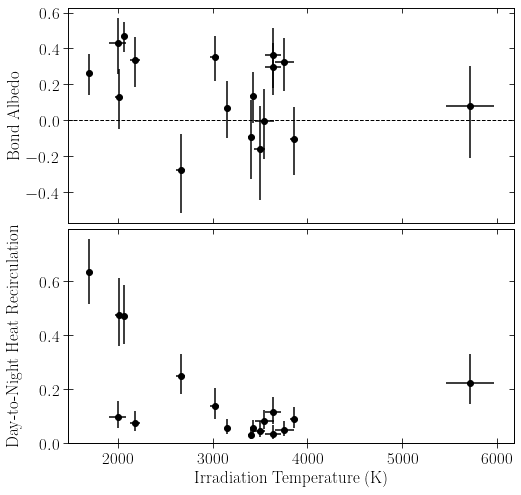

In [6]:
fig1 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=False, passUncert=True)

HD189733b
1692.8471676355907 0.3332905151571962 0.5391439614606021

WASP-43b
1996.1435861357493 0.4646367264919379 0.06423010775368801

Qatar-1b
2005.3995114545771 0.3348515397113418 0.14237871637754923

HD209458b
2064.4829673057175 0.3726797928970229 0.5630584508062061

CoRoT-2b
2179.0434881247634 0.23294519519995727 0.14494945127656986

WASP-14b
2660.810155689226 -0.2744404297266049 0.22965159319037998

WASP-19b
3020.1562928327407 0.3511679259890301 0.13950600686438486

HAT-P-7b
3146.1199796408982 -0.6409288831349345 0.5477611209698673

WASP-18b
3404.30329871404 -0.24283397281351726 0.054441170336014866

KELT-1b
3427.5775740982776 -0.29129849200148716 0.08080870897581412

KELT-16b
3495.926183763988 -0.14850098250268107 0.039458575447031775

WASP-103b
3545.9317422873446 0.13673785081408757 0.04474264390018527

MASCARA-1b
3752.2882277782714 0.3171666286903737 0.04739458441929435

WASP-12b
3636.6149672333186 0.21374498206652615 0.028630393167683725

WASP-12b_old
3635.3376775655474 0.264

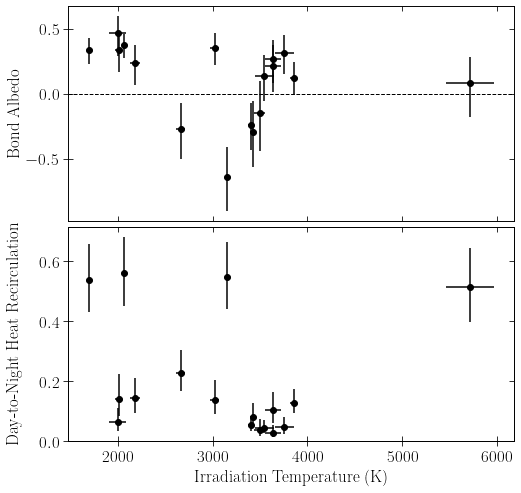

In [7]:
fig2 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=False)

In [9]:
import corner

HD189733b
Knutson+2012
1692.7605482148338 0.2638097331843728 0.6348084137973928

WASP-43b
Stevenson+2017
1996.210050009159 0.4372341251649082 0.09432423540623339

Qatar-1b
Keating+2020
2005.51612944349 0.1401365578195487 0.4585559592799889

HD209458b
Zellem+2014
2064.4429292952664 0.467670260903532 0.4780327058614959

CoRoT-2b
Dang+2018
2178.942912032455 0.35044208429756635 0.07832903848658442

WASP-14b
Wong+2015
2660.6699500706573 -0.2616272449941971 0.24963470213132216

WASP-19b
Wong+2016
3020.1262237719575 0.3547239319024558 0.15172294331763325

HAT-P-7b
Wong+2016
3146.151120012411 0.07036521251832328 0.043637649902647416

WASP-18b
Maxted+2013
3404.16270017703 -0.09850246698981768 0.02499617868661174

KELT-1b
Beatty+2019
3427.473824686612 0.145890962543283 0.0530158493463552

KELT-16b
3495.388446978185 -0.17614890258494698 0.043744705796454286

WASP-103b
Kreidberg+2018
3545.629935391276 0.013407224152821917 0.07673703468382437

MASCARA-1b
3751.471799214365 0.33066744298359546 0.0458

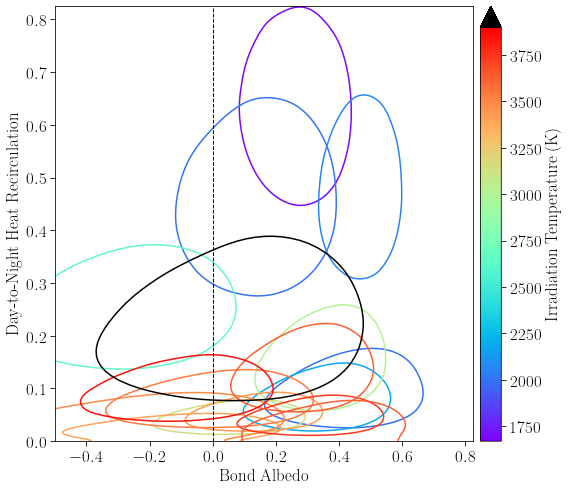

In [10]:
fig3 = make_SchwartzCowan_plot(planets, channels, literature=True, twoD=True)

HD189733b
1692.7705988036273 0.3312173491652581 0.540594076670679

WASP-43b
1995.8809497326488 0.4726189324890152 0.06283487485088246

Qatar-1b
2005.3197417696977 0.35222556668846017 0.127577645415138

HD209458b
2064.481288185648 0.382749068491249 0.5453129967638926

CoRoT-2b
2178.9863643014487 0.2124683852637465 0.14717141426248387

WASP-14b
2660.3809632318985 -0.2696009203409486 0.23328015405740515

WASP-19b
3019.8325030634214 0.35258928624528507 0.14595575656355994

HAT-P-7b
3146.063740838312 -0.5985017604808693 0.5556450382674534

WASP-18b
3404.176898968301 -0.2477092344358629 0.05399374466148153

KELT-1b
3427.347495051336 -0.2763434462640446 0.09196963570534124

KELT-16b
3495.600233981958 -0.14112441398759312 0.0395891759062051

WASP-103b
3546.188854420052 0.15578059191237753 0.045484968960641775

MASCARA-1b
3751.8137869930656 0.30738003374961864 0.052915485387558484

WASP-12b
3637.206358868077 0.2524597690786944 0.030735342515109905

WASP-12b_old
3635.443831626324 0.2921937628525

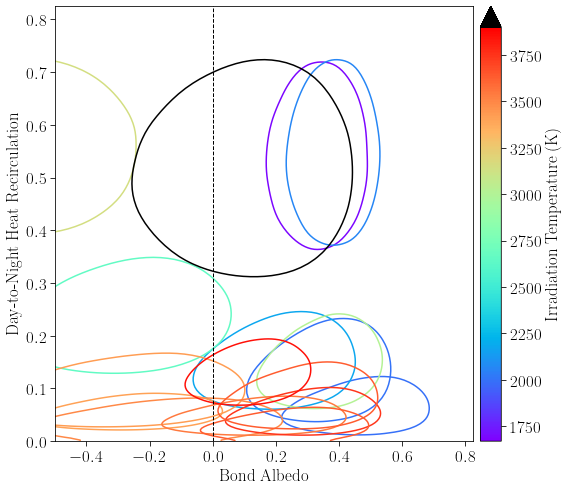

In [11]:
fig4 = make_SchwartzCowan_plot(planets, channels, literature=False, twoD=True)

In [12]:
fig1.savefig('/home/taylor/Downloads/literature_1D_SchwartzReplica.pdf', bbox_inches='tight')
fig2.savefig('/home/taylor/Downloads/reanalysis_1D_SchwartzReplica.pdf', bbox_inches='tight')

In [13]:
fig3.savefig('/home/taylor/Downloads/literature_SchwartzReplica.pdf', bbox_inches='tight')
fig4.savefig('/home/taylor/Downloads/reanalysis_SchwartzReplica.pdf', bbox_inches='tight')

In [14]:
planets

array(['HD189733b', 'WASP-43b', 'Qatar-1b', 'HD209458b', 'CoRoT-2b',
       'WASP-14b', 'WASP-19b', 'HAT-P-7b', 'WASP-18b', 'KELT-1b',
       'KELT-16b', 'WASP-103b', 'MASCARA-1b', 'WASP-12b', 'WASP-12b_old',
       'WASP-33b', 'KELT-9b'], dtype='<U12')

In [6]:
archiveData = Table.to_pandas(Table.read('./masterfile.ecsv'))
names = np.array(archiveData['pl_hostname'])+np.array(archiveData['pl_letter'])
names = np.array([name.replace(' ','').replace('-', '').replace('_','') for name in names])

In [7]:
plotData = []

for i in tqdm(range(len(planets))):
    channel = channels[i]
    planet = planets[i]
        
    # Figure out where files are saved
    phoption = ''
    foldername = ''
    rms = None
    with open(f'{mainpath}{planet}/analysis/{channel}/bestPhOption.txt') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if phoption=='' and lines[i][0]=='/':
            foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
            phoption = lines[i].split('/')[-1].strip()
            i += 1
            ignoreFrames = np.array(lines[i].strip().split('=')[1].strip().replace(' ','').split(','))
            if np.all(ignoreFrames==['']):
                ignoreFrames = np.array([]).astype(int)
            else:
                ignoreFrames = ignoreFrames.astype(int)
            i += 1
            rms = float(lines[i])
        elif phoption!='' and lines[i][0]=='/':
            if float(lines[i+2]) < rms:
                foldername = mainpath+lines[i][lines[i].find(planet):].strip()+'/'
                phoption = lines[i].split('/')[-1].strip()
                i += 1
                ignoreFrames = np.array(lines[i].split('=')[1].strip().replace(' ','').split(','))
                if np.all(ignoreFrames==['']):
                    ignoreFrames = np.array([]).astype(int)
                else:
                    ignoreFrames = ignoreFrames.astype(int)
                i += 1
                rms = float(lines[i])
            else:
                i += 3
    pldFoldernames = np.array(['/'.join(foldername.split('/')[:-2])+'/'+np.array(x)[0].split('/')[-1]+'/' for x in os.walk('/'.join(foldername.split('/')[:-2])+'/') if '4umPLD' in x[0].split('/')[-1] or '3umPLD' in x[0].split('/')[-1]])

    # Figure out what modes were run
    modes = np.sort([x[0].split('/')[-1] for x in os.walk(foldername)][1:])
    for i in range(len(pldFoldernames)):
        modes = np.append(modes, np.sort([x[0].split('/')[-1] for x in os.walk(pldFoldernames[i])][1:]))

    #find the best mode
    bestBIC = np.inf
    ResultMCMC = []
    nData = 0
    for mode in modes:
        if 'PLD' in mode:
            if channel=='ch2':
                folder='4um'
            else:
                folder='3um'
            if '3x3' in mode:
                folder += 'PLD_3x3/'
            else:
                folder += 'PLD_5x5/'
            savepath   = '/'.join(foldername.split('/')[:-2])+'/'+folder + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'
        else:
            savepath   = foldername + mode + '/'+ 'ResultMCMC_'+mode+'_Params.npy'

        if not os.path.exists(savepath):
            continue

        ResultMCMC_temp = np.load(savepath)
        BIC = -2*ResultMCMC_temp['evidenceB'][0]
        if BIC<bestBIC:
            bestBIC = BIC
            ResultMCMC = ResultMCMC_temp
            nData = ResultMCMC['chi2B'][0]/ResultMCMC['chi2datum'][0]

    if bestBIC==np.inf:
        continue #no analyses for this planet
    
    nameIndex = np.where(names==planet.replace(' ','').replace('-', '').split('_')[0])[0][0]
    mass = [archiveData['pl_massj'][nameIndex], np.mean([archiveData['pl_massjerr1'][nameIndex],
                                                         np.abs(archiveData['pl_massjerr2'][nameIndex])])]
    density = [archiveData['pl_dens'][nameIndex], np.mean([archiveData['pl_denserr1'][nameIndex],
                                                           np.abs(archiveData['pl_denserr2'][nameIndex])])]
    period = [archiveData['pl_orbper'][nameIndex], np.mean([archiveData['pl_orbpererr1'][nameIndex],
                                                            np.abs(archiveData['pl_orbpererr2'][nameIndex])])]
    
    feh = [archiveData['st_metfe'][nameIndex], np.mean([archiveData['st_metfeerr1'][nameIndex],
                                                        np.abs(archiveData['st_metfeerr2'][nameIndex])])]
    
    Tstar = [archiveData['st_teff'][nameIndex], np.mean([archiveData['st_tefferr1'][nameIndex],
                                                         np.abs(archiveData['st_tefferr2'][nameIndex])])]
    
    Rstar = [archiveData['st_rad'][nameIndex], np.mean([archiveData['st_raderr1'][nameIndex],
                                                       np.abs(archiveData['st_raderr2'][nameIndex])])]

    if planet=='KELT-1b':
        Tstar = [6518, 50]
        Rstar = [1.462, 0.037]
        feh = [0.052,0.079]
    elif planet=='WASP-33b':
        feh = [0.10,0.]
    elif planet=='MASCARA-1b':
        feh = [0,0]
    
    if np.all(np.isnan(ResultMCMC['fp'])):
        continue
    
    newTb = recompute_Tb(ResultMCMC['fp'], ResultMCMC['rp'], ResultMCMC['A'],
                         planet, channel, mainpath)
    Tday = newTb[[0,1,2]]
    Tnight = newTb[[3,4,5]]
    
    n = int(1.5e5)    
    Tstar = np.random.normal(Tstar[0],  Tstar[1], n)
    a_down = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][2], n)
    a_up = np.random.normal(ResultMCMC['a'][0], ResultMCMC['a'][1], n)
    a = np.append(a_down[a_down<ResultMCMC['a'][0]], a_up[a_up>=ResultMCMC['a'][0]])
    
    # Update day and nightside uncertainties using Pass+2019
    bands = np.array([4.493e-6])  # central wavelengths of observed bands (m)
    td_brights = np.array([Tday[0]])  # brightness temperatures in these bands (K)
    td_uncs = np.array([np.mean(Tday[1:])])  # uncertainties on brightness temperatures (K)
    tn_brights = np.array([Tnight[0]])  # brightness temperatures in these bands (K)
    tn_uncs = np.array([np.mean(Tnight[1:])])  # uncertainties on brightness temperatures (K)

    Tday = np.array(pass_uncerts(bands, td_brights, td_uncs))
    Tnight = np.array(pass_uncerts(bands, tn_brights, tn_uncs))

    Td = np.random.normal(Tday[0], Tday[1], n)
    Tn = np.random.normal(Tnight[0], Tday[1], n)
    
    n = np.min([Td.size, Tn.size, Tstar.size, a.size])
    Td = Td[np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][np.random.randint(0, Td.size, Td.size)][:n]
    Tn = Tn[np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][np.random.randint(0, Tn.size, Tn.size)][:n]
    a = a[np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][np.random.randint(0, a.size, a.size)][:n]
    Tstar = Tstar[:n]
    
    T0 = Tstar*np.sqrt(1/a)
    
    eps = 8/(5+3*(Td/Tn)**4) 
    AB = 1-(5*Tn**4+3*Td**4)/(2*T0**4)
    
    Tstar = np.append([np.median(Tstar)], np.mean(np.abs(np.percentile(Tstar, [16, 84])-np.median(Tstar))))
    T0 = np.append([np.median(T0)], np.mean(np.abs(np.percentile(T0, [16, 84])-np.median(T0))))
    eps = np.append([np.median(eps)], np.mean(np.abs(np.percentile(eps, [16, 84])-np.median(eps))))
    AB = np.append([np.median(AB)], np.mean(np.abs(np.percentile(AB, [16, 84])-np.median(AB))))
    
    A = ResultMCMC['A']
    A = np.array([A[0], np.mean(np.abs(A[1:]))])
    offset = ResultMCMC['offset']
    offset = np.array([offset[0], np.mean(np.abs(offset[1:]))])
    rp_rs = ResultMCMC['rp']
    rp_rs = np.array([rp_rs[0], np.mean(np.abs(rp_rs[1:]))])
    logMass = np.log(mass)
    
    rp_rs_sim = np.random.normal(rp_rs[0], rp_rs[1], int(1e5))
    rs_sim = np.random.normal(Rstar[0], Rstar[1], int(1e5))
    mass_sim = np.random.normal(mass[0], mass[1], int(1e5))
    rp_sim = rp_rs_sim*rs_sim*const.R_sun.value/const.R_jup.value
    rp = [np.median(rp_sim), np.mean(np.abs(np.percentile(rp_sim, [16, 84])-np.median(rp_sim)))]
    
    logg_pl_sim = np.log(const.G.value*mass_sim*const.M_jup.value/((rp_sim*const.R_jup.value)**2))
    logg_pl = [np.nanmedian(logg_pl_sim), np.nanmean(np.abs(np.nanpercentile(logg_pl_sim, [16, 84])-np.nanmedian(logg_pl_sim)))]
    
    plotData.append([Tstar, T0, Tday, Tnight, A, offset, eps, AB, rp, mass, logMass, density, logg_pl, period, feh])
    
plotData = np.array(plotData)

100%|██████████| 17/17 [01:31<00:00,  5.36s/it]


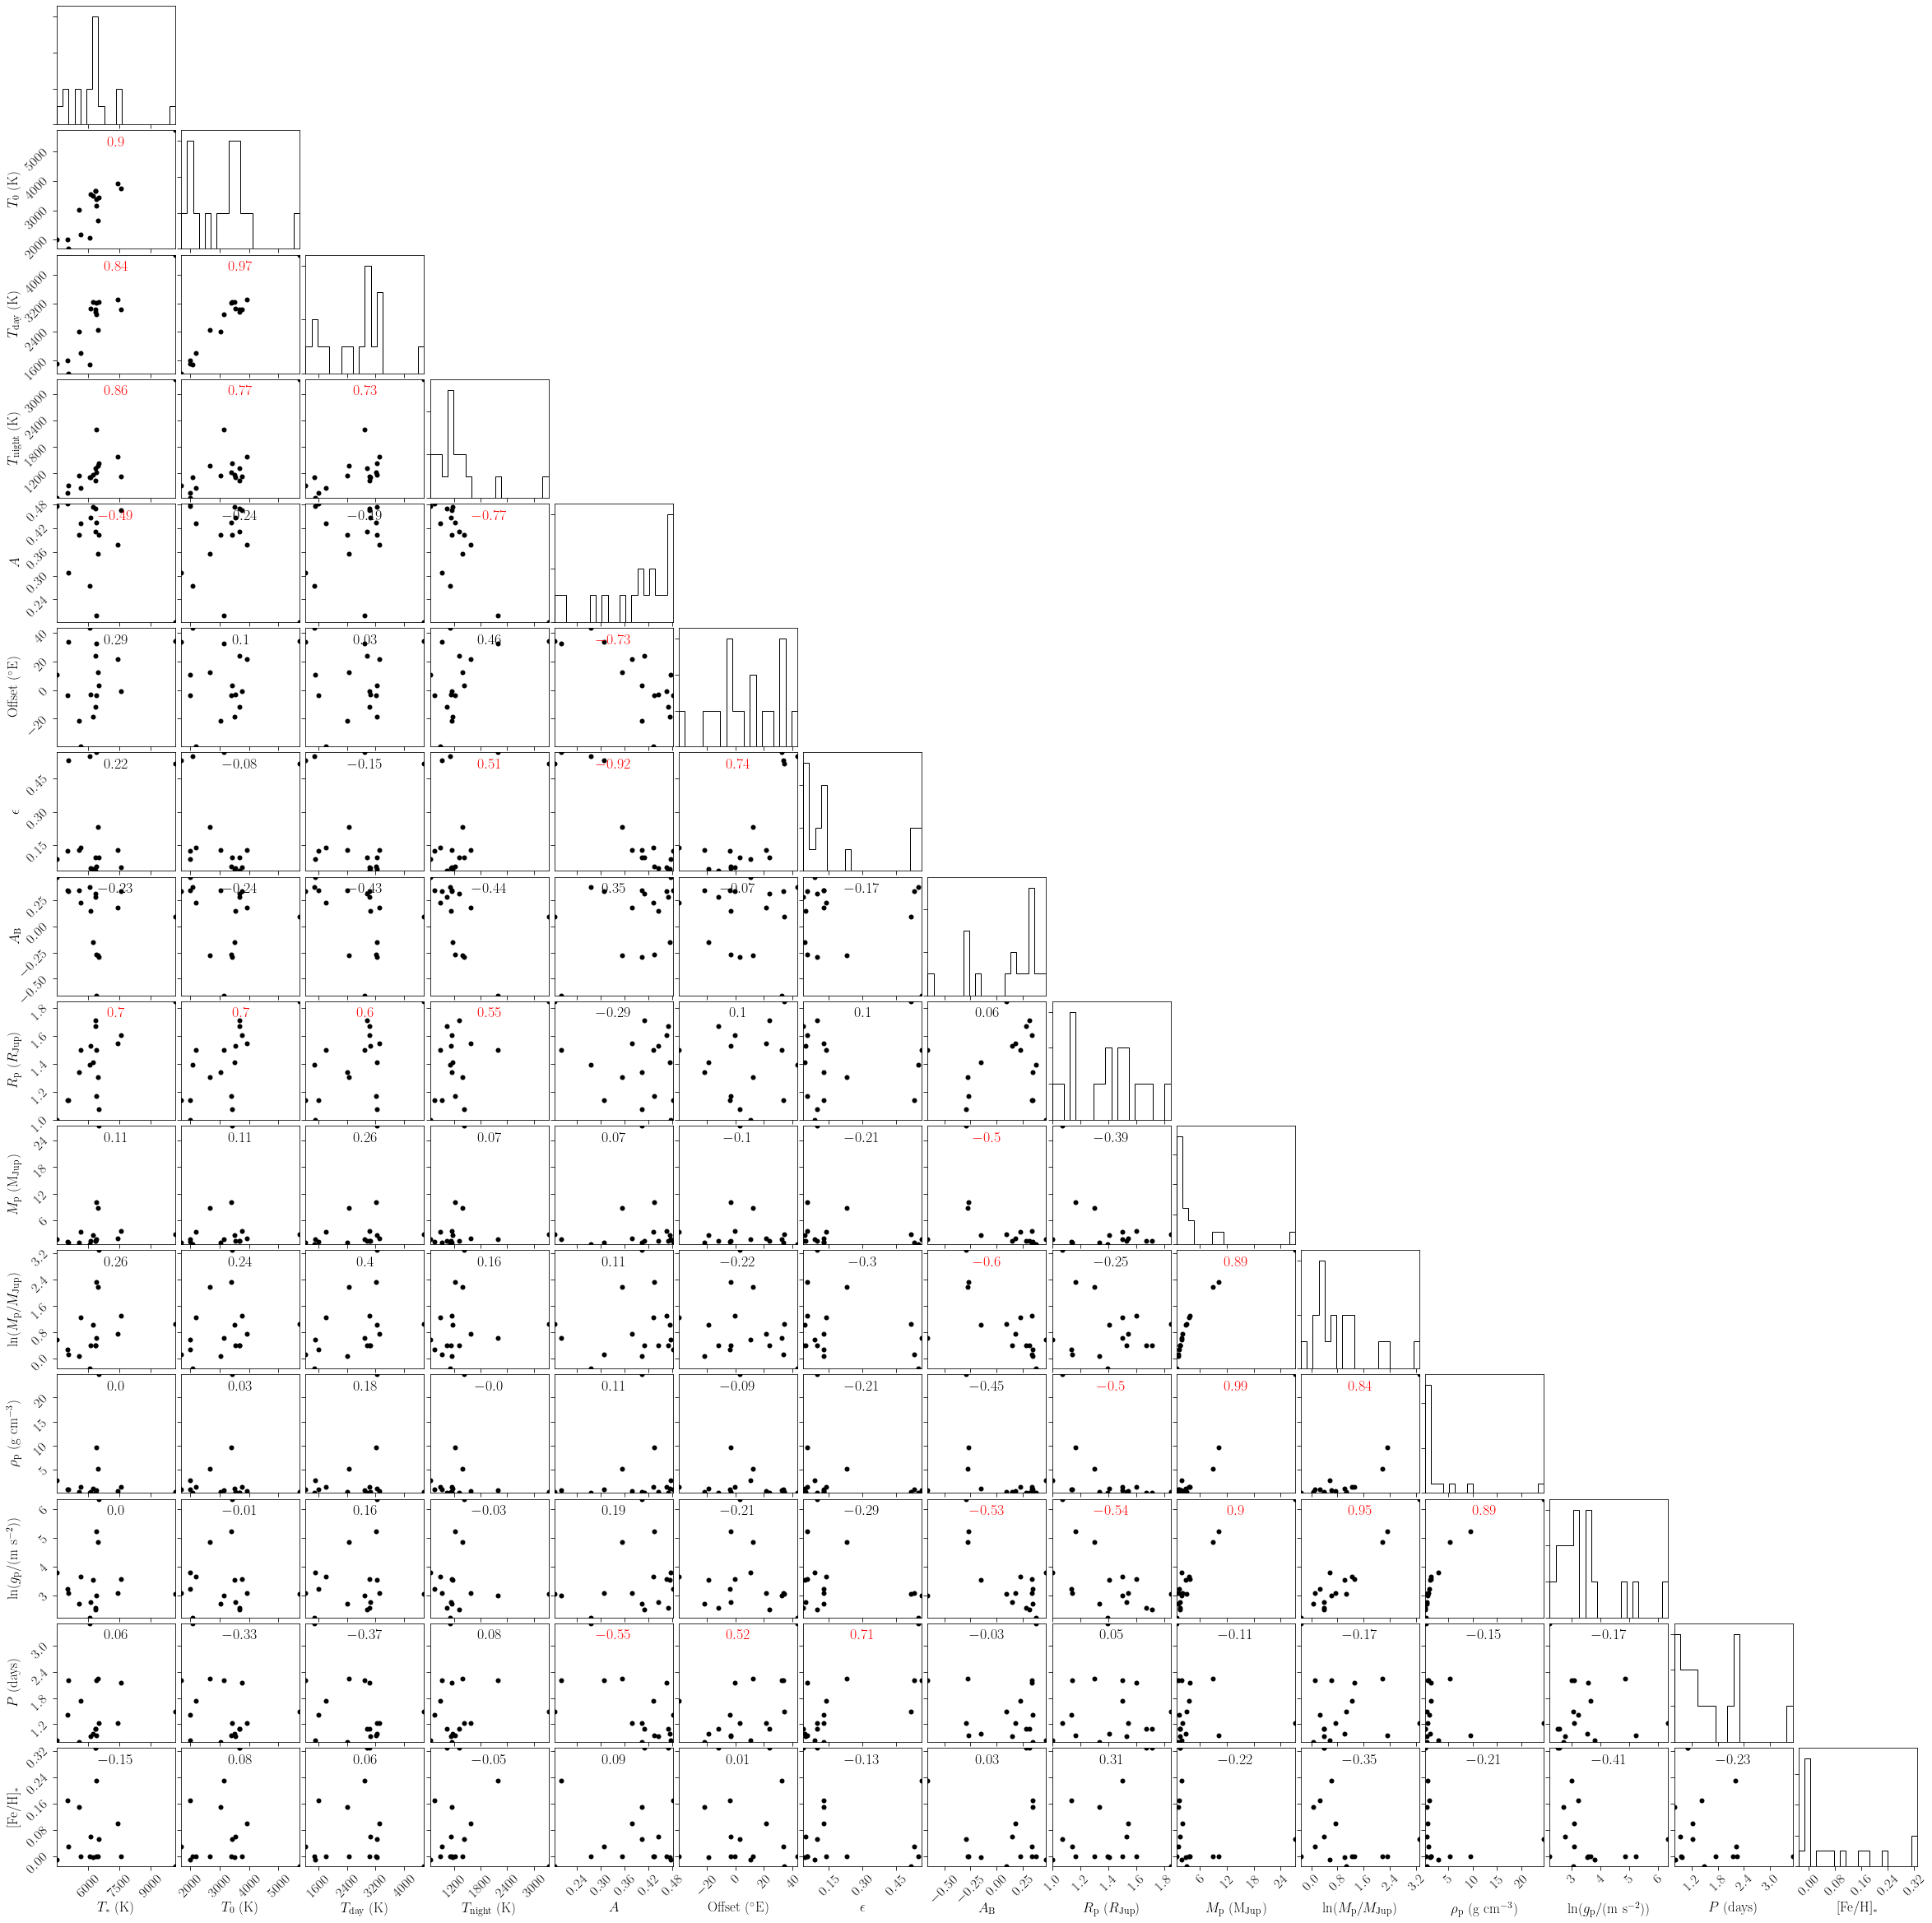

In [8]:
labels=[r'$T_{\rm *}~\rm (K)$', r'$T_{\rm 0}~\rm (K)$', r'$T_{\rm day}~\rm (K)$', r'$T_{\rm night}~\rm (K)$',
        r'$A$', r'$\rm Offset~\rm (^{\circ}E)$', r'$\epsilon$', r'$A_{\rm B}$',
        r'$R_{\rm p}~(R_{\rm Jup})$', r'$M_{\rm p}~\rm (M_{\rm Jup})$', r'$\ln(M_{\rm p}/M_{\rm Jup})$',
        r'$\rho_{\rm p}~\rm (g~cm^{-3})$', r'$\ln(g_{\rm p} / ({\rm m~s^{-2}}))$', r'$P~\rm (days)$',
        r'$\rm [Fe/H]_{\rm *}$']

corner(plotData[:,:,0], labels=labels,
       plot_datapoints=True, plot_density=False, plot_contours=False, data_kwargs={'ms':6, 'alpha':1, 'color':'k'})
figure = plt.gcf()

axes = np.array(figure.get_axes()).reshape(plotData.shape[1], plotData.shape[1])
for indX, x in enumerate(plotData[:,:,0].T):
    nameX = labels[indX]
    for indY, y in enumerate(plotData[:,(indX+1):,0].T):
        nameY = labels[(indX+1):][indY]
        r = pearsonr(x,y)
        axes[indY+indX+1, indX].text(0.5, 0.95, '$'+str(np.round(r[0], 2))+'$', horizontalalignment='center', verticalalignment='top', transform=axes[indY+indX+1, indX].transAxes, color=['black', 'red'][int(r[1]<0.05)], fontsize=18)

figure.patch.set_facecolor('white')
        
figure.savefig('/home/taylor/Downloads/PC_corner.pdf', bbox_inches='tight')
figure.savefig('/home/taylor/Downloads/PC_corner.png', dpi=300, bbox_inches='tight')
# plt.show()

In [9]:
np.isin(planets,['KELT-16b', 'MASCARA-1b']), planets[np.isin(planets,['KELT-16b', 'MASCARA-1b'])]

(array([False, False, False, False, False, False, False, False, False,
        False,  True, False,  True, False, False, False, False]),
 array(['KELT-16b', 'MASCARA-1b'], dtype='<U12'))

In [18]:
plotData[np.isin(planets,['KELT-16b', 'MASCARA-1b']),np.array(labels)==r'$\epsilon$',:]

array([[0.0431527 , 0.03027029],
       [0.05146809, 0.02718978]])

In [19]:
plotData[np.isin(planets,['KELT-16b']),np.array(labels)==r'$\epsilon$',:]

array([[0.0431527 , 0.03027029]])

(-0.6063832837350924, 0.009863759840812883)


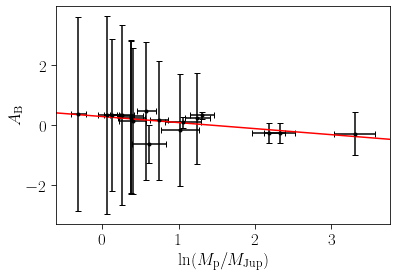

In [41]:
indX = 7
indY = -4

nameX = labels[indY]
nameY = labels[indX]

x = plotData[:,indY,0]
y = plotData[:,indX,0]

xerr = plotData[:,indX,1]
yerr = plotData[:,indY,1]

r = pearsonr(x,y)
print(r)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

xlim = plt.gca().get_xlim()
polyVars = np.polyfit(x, y, 1)
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(r'$\ln(M_{\rm p}/M_{\rm Jup})$')
plt.show()

1
(0.896450097826065, 1.1124020839516658e-06)
[ 7.02793047e-01 -1.31981182e+03]


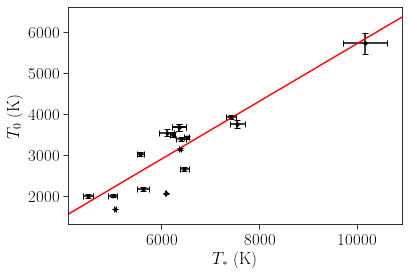

2
(0.8413482531191588, 2.3094608382753788e-05)
[ 5.83920006e-01 -1.05452926e+03]


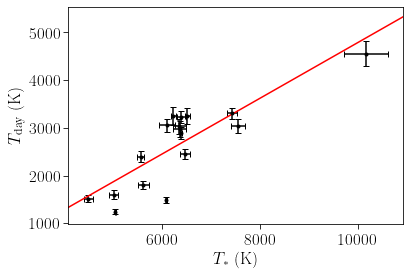

3
(0.8621324958231741, 8.583626320180626e-06)
[ 4.28273241e-01 -1.40069564e+03]


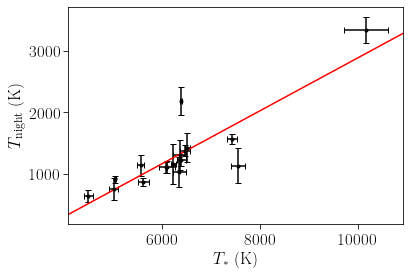

4
(-0.4871015557163075, 0.047356515855354074)
[-3.64577168e-05  6.19032058e-01]


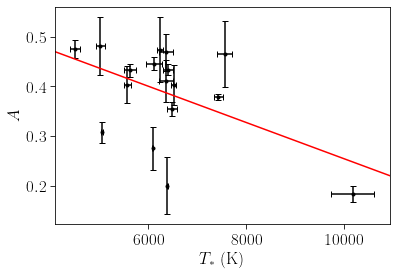

5
(0.6977615424704618, 0.0018437404136466436)
[1.34172661e-04 5.53082841e-01]


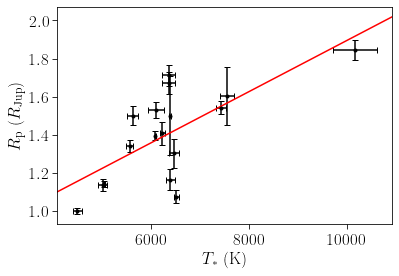

6
(0.9704136873459409, 1.1494694865186133e-10)
[  0.85907906 -46.54290468]


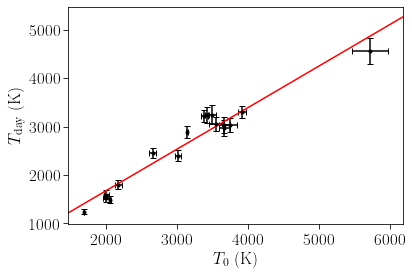

7
(0.7691264497117781, 0.0003075259250878591)
[   0.48735265 -213.368233  ]


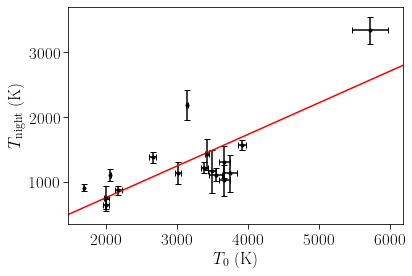

8
(0.7027299680559085, 0.0016547753503274067)
[1.72363038e-04 8.63280010e-01]


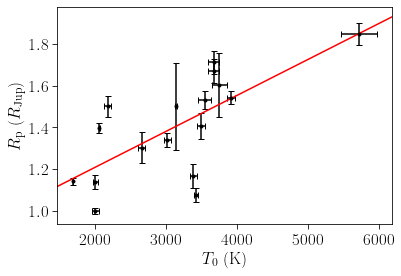

9
(0.7331596180584291, 0.0008122800510230937)
[  0.52476868 -74.26593582]


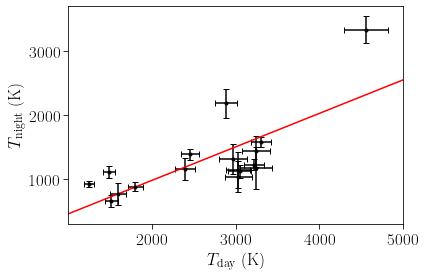

10
(0.5981308405143019, 0.011205421223128328)
[1.65720273e-04 9.65147210e-01]


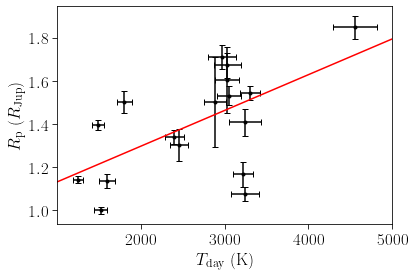

11
(-0.7651898896579991, 0.00034478113012101157)
[-1.15290162e-04  5.39500165e-01]


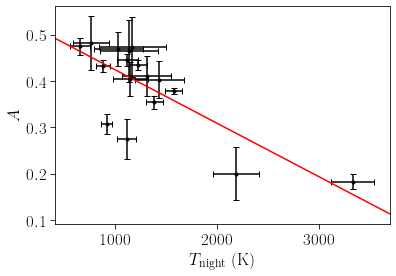

12
(0.5117250700732072, 0.03574975066937568)
[ 0.00016343 -0.01392648]


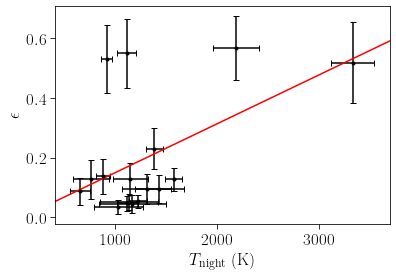

13
(0.554295989064358, 0.020944935927532087)
[2.14561509e-04 1.12186287e+00]


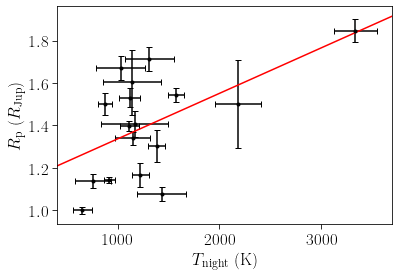

14
(-0.7299639061381636, 0.0008790707631294083)
[-176.66962005   75.18905492]


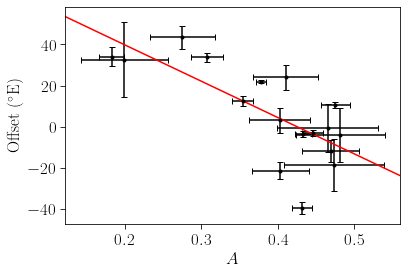

15
(-0.9225401108319474, 1.3628402076976708e-07)
[-1.95553611  0.95944341]


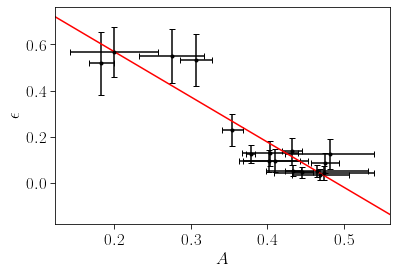

16
(-0.5493847347573586, 0.02235355945863129)
[-4.2508659   3.18015834]


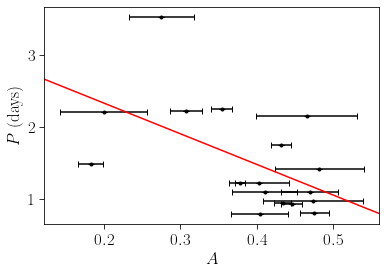

17
(0.7364540734553269, 0.0007478794615481083)
[0.00645009 0.15807413]


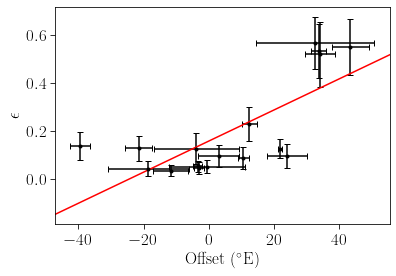

18
(0.5246142935231077, 0.030614807694735756)
[0.01677183 1.41977643]


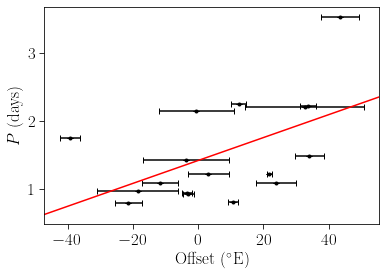

19
(0.7082842914562064, 0.0014626604301025679)
[2.58540059 1.01173194]


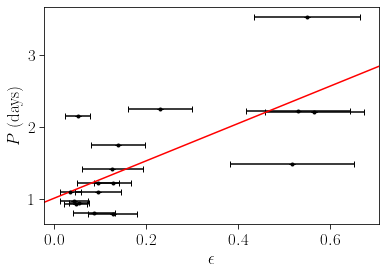

20
(-0.49867532400699255, 0.04159305330030499)
[-10.13685066   5.40177788]


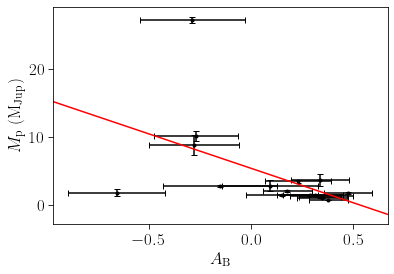

21
(-0.6020307537976738, 0.010554424406313346)
[-1.76537705  1.10896951]


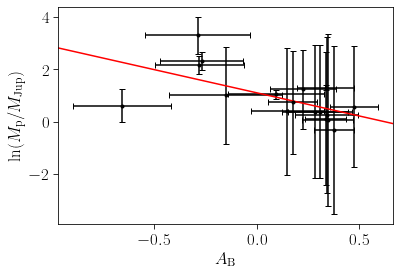

22
(-0.5305109675680786, 0.028463869686974903)
[-1.80268617  3.67151252]


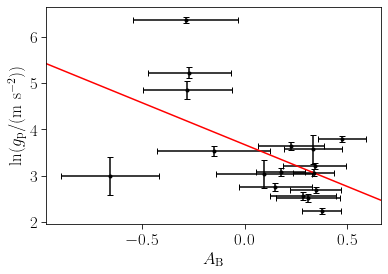

23
(-0.4961593822176147, 0.04279818866267806)
[-12.38567684  20.49008356]


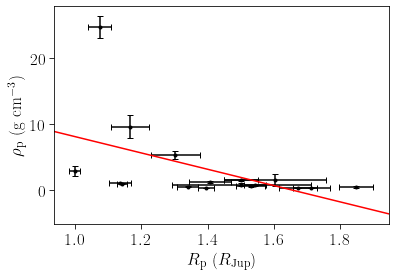

24
(-0.5447268160483131, 0.023756538415964222)
[-2.43103765  6.89290496]


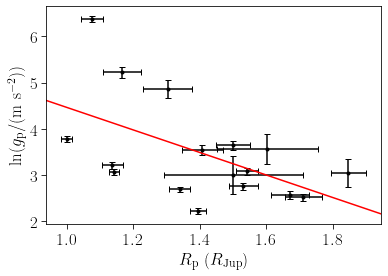

25
(0.8901058337444383, 1.7048693804201712e-06)
[0.12840303 0.36583437]


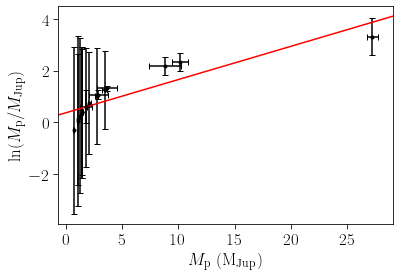

26
(0.9867369900464851, 2.9352133696906936e-13)
[ 0.92263007 -0.88817856]


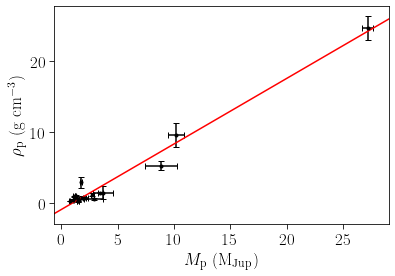

27
(0.9010128009485999, 8.042797857952097e-07)
[0.15061615 2.82845043]


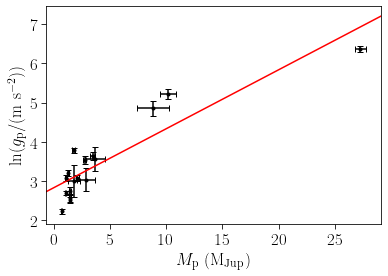

28
(0.8405663053129145, 2.3904761125516617e-05)
[ 5.44834428 -1.91799446]


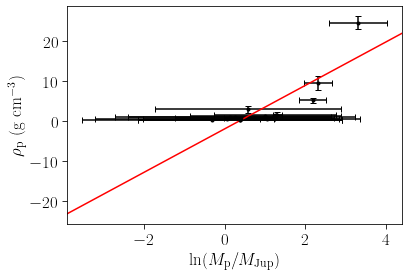

29
(0.9486012637028315, 6.789529946649743e-09)
[1.09923528 2.46721935]


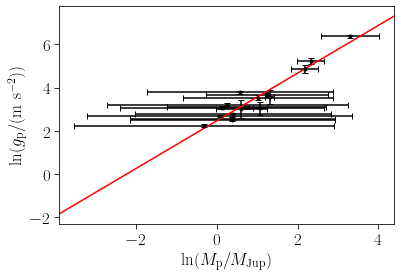

30
(0.8929583791082658, 1.4116987538714137e-06)
[0.15964143 2.98460683]


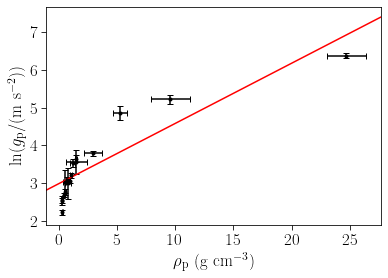

In [20]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            print(i)
            print(r)
            
            plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

            xlim = plt.gca().get_xlim()
            polyVars = np.polyfit(x, y, 1)
            x_smooth = np.linspace(xlim[0], xlim[1], 100)
            y_smooth = np.polyval(polyVars, x_smooth)
            plt.plot(x_smooth, y_smooth, '-', c='r')

            print(polyVars)
            
            plt.xlim(*xlim)
            plt.ylabel(nameY)
            plt.xlabel(nameX)
            plt.show()

In [17]:
import emcee
def loglike(polyVars, x, y, yerr):
    #slope, inter = polyVars
    slope = polyVars
    return -0.5*np.sum((y-slope*x)**2/yerr**2)

7
[2.39300406e-01 4.77261988e+02]


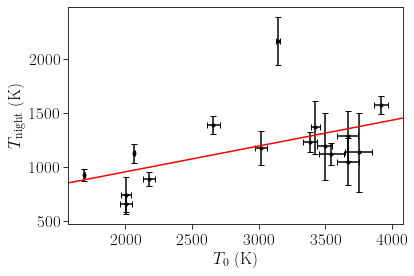

In [14]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                xlim = plt.gca().get_xlim()
                polyVars = np.polyfit(x, y, 1)
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

7


100%|██████████| 100000/100000 [01:05<00:00, 1523.17it/s]


Mean acceptance fraction: 0.806
0.42437874881432114 0.01081618613703067
[0.42437874881432114, 0]


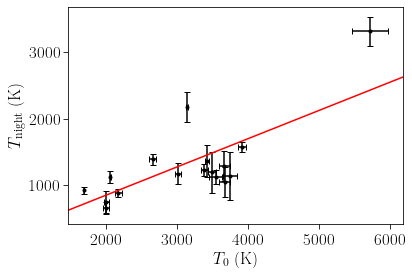

In [49]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

7


100%|██████████| 100000/100000 [01:05<00:00, 1519.32it/s]


Mean acceptance fraction: 0.806
0.4147023942056524 0.010791144542079072
[0.4147023942056524, 0]


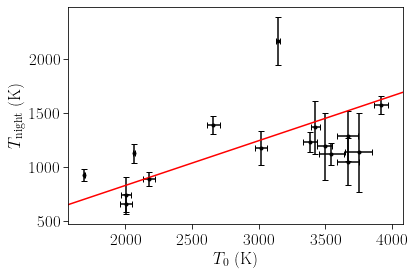

In [50]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)
                
                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

7
[0.4240629875368648, 0]


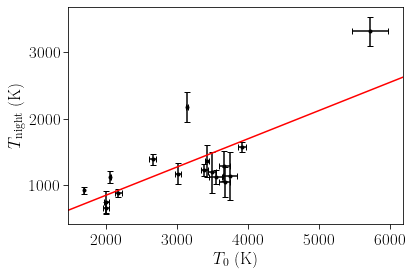

In [63]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==7:
            
                print(i)
                
#                 x = x[planets!='KELT-9b']
#                 y = y[planets!='KELT-9b']
#                 xerr = xerr[planets!='KELT-9b']
#                 yerr = yerr[planets!='KELT-9b']

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
#                     slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
                #2.39300406e-01 4.77261988
                polyVars = scipy.optimize.minimize(line, [2.39300406e-01], args=(x,y), method='Nelder-Mead').x
                
#                 junkier = 1
                
#                 nwalkers = 20
#                 pos0 = np.random.normal(1,0.1,(nwalkers,1))
#                 sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
#                 pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
#                 print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

#                 print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
#                 polyVars = [np.median(sampler.flatchain),0]
                
                polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

6


100%|██████████| 100000/100000 [01:06<00:00, 1493.61it/s]


Mean acceptance fraction: 0.806
[0.831668143612291, 0]


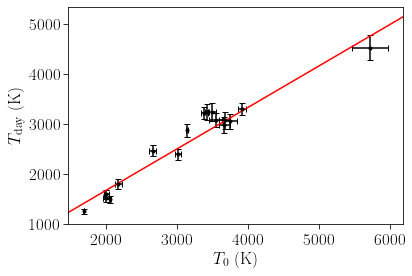

In [46]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==6:
            
                print(i)

                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

6


100%|██████████| 100000/100000 [01:04<00:00, 1540.44it/s]


Mean acceptance fraction: 0.806
0.8336110835833128 0.009964109027816857
[0.8336110835833128, 0]


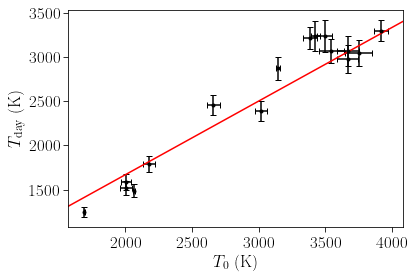

In [64]:
i = 0
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    for indY_temp in range(plotData[:,(indX+1):,:].shape[1]):
        indY = indY_temp+(indX+1)
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        if r[1]<0.05:
            i +=1
            if i in [0]:#,1,2,3,4,5]:
                continue
            
            if i==6:
            
                print(i)

                x = x[planets!='KELT-9b']
                y = y[planets!='KELT-9b']
                xerr = xerr[planets!='KELT-9b']
                yerr = yerr[planets!='KELT-9b']
                
                plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

                def line(polyVars, x, y):
                    #slope, inter = polyVars
                    slope = polyVars
                    return np.mean((y-slope*x)**2)
                
                xlim = plt.gca().get_xlim()
#                 polyVars = np.polyfit(x, y, 1)
#                 polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x
                
                junkier = 1
                
                nwalkers = 20
                pos0 = np.random.normal(1,0.1,(nwalkers,1))
                sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
                pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
                print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

                print(np.median(sampler.flatchain), np.std(sampler.flatchain))
                
                polyVars = [np.median(sampler.flatchain),0]
                
#                 polyVars = [polyVars[0],0]
                x_smooth = np.linspace(xlim[0], xlim[1], 100)
                y_smooth = np.polyval(polyVars, x_smooth)
                plt.plot(x_smooth, y_smooth, '-', c='r')

                print(polyVars)

                plt.xlim(*xlim)
                plt.ylabel(nameY)
                plt.xlabel(nameX)
                plt.show()

In [106]:
print('&', ' & '.join(labels)+' \\\\')
for indX in range(plotData.shape[1]):
    nameX = labels[indX]
    string = nameX+' & '
    for indY_temp in range(plotData.shape[1]):
        indY = indY_temp
        nameY = labels[indY]
        
        x = plotData[:,indX,0]
        y = plotData[:,indY,0]
        xerr = plotData[:,indX,1]
        yerr = plotData[:,indY,1]

        r = pearsonr(x,y)
        
        string += format(np.round(r[0], 2), '0.2f')+' & '
    string = string[:-3]+' \\\\'
    print(string)

& $T_{\rm *}~\rm (K)$ & $T_{\rm 0}~\rm (K)$ & $T_{\rm day}~\rm (K)$ & $T_{\rm night}~\rm (K)$ & $A$ & $\rm Offset~\rm (^{\circ}E)$ & $\epsilon$ & $A_{\rm B}$ & $R_{\rm p}~(R_{\rm Jup})$ & $M_{\rm p}~\rm (M_{\rm Jup})$ & $\ln(M_{\rm p}/M_{\rm Jup})$ & $\rho_{\rm p}~\rm (g~cm^{-3})$ & $\ln(g_{\rm p} / ({\rm m~s^{-2}}))$ & $P~\rm (days)$ & $\rm [Fe/H]_{\rm *}$ \\
$T_{\rm *}~\rm (K)$ & 1.00 & 0.90 & 0.84 & 0.87 & -0.49 & 0.29 & 0.22 & -0.24 & 0.70 & 0.11 & 0.26 & 0.00 & 0.00 & 0.06 & -0.15 \\
$T_{\rm 0}~\rm (K)$ & 0.90 & 1.00 & 0.97 & 0.78 & -0.24 & 0.10 & -0.08 & -0.24 & 0.70 & 0.11 & 0.24 & 0.03 & -0.01 & -0.33 & 0.08 \\
$T_{\rm day}~\rm (K)$ & 0.84 & 0.97 & 1.00 & 0.74 & -0.19 & 0.03 & -0.16 & -0.43 & 0.60 & 0.26 & 0.40 & 0.18 & 0.16 & -0.37 & 0.07 \\
$T_{\rm night}~\rm (K)$ & 0.87 & 0.78 & 0.74 & 1.00 & -0.76 & 0.45 & 0.50 & -0.42 & 0.56 & 0.07 & 0.16 & -0.01 & -0.04 & 0.08 & -0.06 \\
$A$ & -0.49 & -0.24 & -0.19 & -0.76 & 1.00 & -0.73 & -0.92 & 0.34 & -0.29 & 0.07 & 0.11 & 0.11 & 0.19 

In [103]:
''.join(['c|' for label in labels])

'c|c|c|c|c|c|c|c|c|c|c|c|c|c|c|'

In [13]:
junk = '''979±58 979±58 1015±86 792±64 1098±201 1267±111 986±233 1507±285 1128±108 815±463 1528±108 1256±386 1776±165'''.split(' ')
junk = np.array([junk[i].split('±') for i in range(len(junk))]).astype(float)

array([ 979.,  979., 1015.,  792., 1098., 1267.,  986., 1507., 1128.,
        815., 1528., 1256., 1776.])

100%|██████████| 100000/100000 [01:17<00:00, 1288.75it/s]


Mean acceptance fraction: 0.807
0.44030953601435824 0.0126845415527591
[0.44030953601435824, 0]


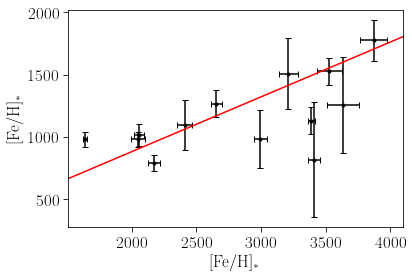

In [18]:
x = [1636,2051,2053,2175,2411, 2654,2995, 3211,3391,3412,3530,3636,3874]
y = junk[:,0]
xerr = [14,53,38,47,59,43,52,75,29,49,99,121,104]
yerr = junk[:,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

def line(polyVars, x, y):
    #slope, inter = polyVars
    slope = polyVars
    return np.mean((y-slope*x)**2)

xlim = plt.gca().get_xlim()
# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(line, [1,], args=(x,y), method='Nelder-Mead').x

junkier = 1

nwalkers = 20
pos0 = np.random.normal(1,0.1,(nwalkers,1))
sampler = emcee.EnsembleSampler(nwalkers, 1, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain), np.std(sampler.flatchain))

polyVars = [np.median(sampler.flatchain),0]

# polyVars = [polyVars[0],0]
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')

print(polyVars)

plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [9]:
import emcee
import scipy
def loglike(polyVars, x, y, yerr):
    model = line(polyVars, x, y)
    return -0.5*np.sum((y-model)**2/yerr**2)

def neg_loglike(polyVars, x, y, yerr):
    return -loglike(polyVars, x, y, yerr)

def line(polyVars, x, y):
    if len(polyVars)==2:
        slope, inter = polyVars
    else:
        slope = polyVars
        inter = 0
    return slope*x+inter

100%|██████████| 100000/100000 [01:23<00:00, 1201.50it/s]


Mean acceptance fraction: 0.716
[ 0.08273687 -0.02498147] [0.0225005  0.02804079]
[ 0.08273687 -0.02498147]


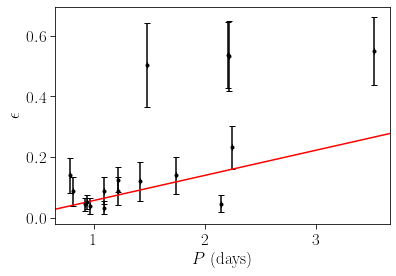

In [10]:
indX = -2
indY = -9

nameX = labels[indX]
nameY = labels[indY]

x = plotData[:,indX,0]
y = plotData[:,indY,0]
xerr = plotData[:,indX,1]
yerr = plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
# polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e5, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1111.32it/s]


Mean acceptance fraction: 0.716
[-0.15243752  0.73217856] [0.0208092  0.03270999]
[-0.15243752  0.73217856]


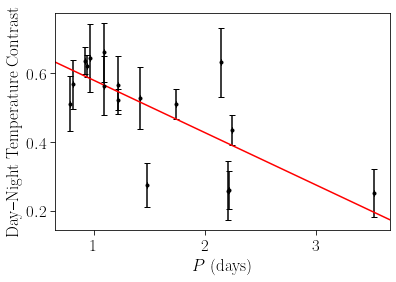

In [11]:
indX = -2

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

100%|██████████| 10000/10000 [00:08<00:00, 1199.86it/s]


Mean acceptance fraction: 0.713
[2.87053237e-05 4.20316201e-01] [1.50810545e-05 5.02269539e-02]
[2.87053237e-05 4.20316201e-01]


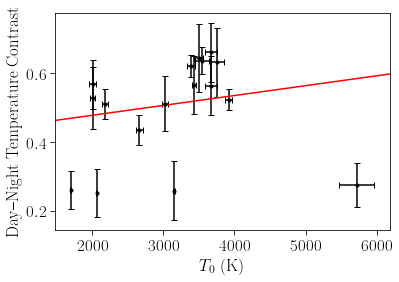

In [12]:
indX = 1

nameY = r'$\rm Day$--$\rm Night~Temperature~Contrast$'
nameX = labels[indX]

x = plotData[:,indX,0]
y = (1-plotData[:,3,0]/plotData[:,2,0])
xerr = plotData[:,indX,1]
yerr = np.sqrt((plotData[:,3,1]/plotData[:,2,0])**2+(plotData[:,3,0]/plotData[:,2,0]**2*plotData[:,2,1])**2)#plotData[:,indY,1]

r = pearsonr(x,y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', capsize=3, color='black')

# polyVars = np.polyfit(x, y, 1)
polyVars = scipy.optimize.minimize(neg_loglike, [1,0], args=(x,y,yerr), method='Nelder-Mead').x

nwalkers = 20
ndim = 2
pos0 = polyVars*np.random.normal(1,0.1,(nwalkers,ndim))
sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike, args=(x,y,yerr), a = 2)
pos2, prob, state = sampler.run_mcmc(pos0, 1e4, progress=True)
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

print(np.median(sampler.flatchain, axis=0), np.std(sampler.flatchain, axis=0))

polyVars = np.median(sampler.flatchain, axis=0)
# polyVars = [np.median(sampler.flatchain),0]
# polyVars = [polyVars[0],0]
print(polyVars)

xlim = plt.gca().get_xlim()
x_smooth = np.linspace(xlim[0], xlim[1], 100)
y_smooth = np.polyval(polyVars, x_smooth)
plt.plot(x_smooth, y_smooth, '-', c='r')
plt.xlim(*xlim)
plt.ylabel(nameY)
plt.xlabel(nameX)
plt.show()

In [13]:
planets[y<0.4]

array(['HD189733b', 'HD209458b', 'HAT-P-7b', 'KELT-9b'], dtype='<U12')

In [16]:
plotData[:,-2,0][y<0.4]

array([2.21857567, 3.52474859, 2.20474   , 1.4811235 ])

In [17]:
planets[y<0.45]

array(['HD189733b', 'HD209458b', 'WASP-14b', 'HAT-P-7b', 'KELT-9b'],
      dtype='<U12')